# HERBS RECOGNITION
### Model Training Notebook<br>
Andrey Kozinov 2021

In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/KLS/HERBS_NEW')

In [2]:
import time
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import copy

warnings.filterwarnings('ignore')

## DATASET AND DATALOADER

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(400),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(400),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=8)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = len(class_names)
print("Number of classes = ", num_classes)
print("Dataset size", dataset_sizes)

Number of classes =  71
Dataset size {'train': 981, 'val': 389}


## DATASET VISUALIZATION



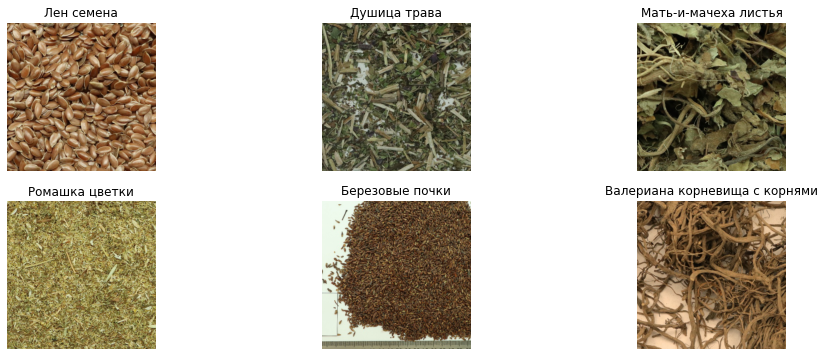

In [4]:
def im_convert(tensor):
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std])
    inv_tensor = inv_normalize(tensor)
    image = inv_tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    return image


plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image, label = dataloaders['train'].dataset.__getitem__(np.random.choice(563))
    plt.imshow(im_convert(image))
    plt.title(class_names[label], color='black')
    plt.axis('off')
plt.show();

## MODEL TRAINING

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
stat_train = dict()
for inputs, labels in image_datasets['train']:
    if labels not in stat_train:
        stat_train[labels] = 0
    stat_train[labels] += 1

weights = torch.tensor(np.fromiter(stat_train.values(), dtype=float) / dataset_sizes['train'], dtype=torch.float,
                       device='cuda')

In [7]:
# %%
model_ft = models.resnext50_32x4d(pretrained=True, progress=True)  # resnext50_32x4d
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 1.8424 Acc: 0.2956
val Loss: 1.0049 Acc: 0.4859

Epoch 1/39
----------
train Loss: 1.1186 Acc: 0.4475
val Loss: 0.6051 Acc: 0.6247

Epoch 2/39
----------
train Loss: 1.0093 Acc: 0.5260
val Loss: 0.5230 Acc: 0.6401

Epoch 3/39
----------
train Loss: 0.8550 Acc: 0.5556
val Loss: 0.3976 Acc: 0.6941

Epoch 4/39
----------
train Loss: 0.6368 Acc: 0.6310
val Loss: 0.4129 Acc: 0.7172

Epoch 5/39
----------
train Loss: 0.5145 Acc: 0.6799
val Loss: 0.3681 Acc: 0.7378

Epoch 6/39
----------
train Loss: 0.5045 Acc: 0.6922
val Loss: 0.2953 Acc: 0.7558

Epoch 7/39
----------
train Loss: 0.4173 Acc: 0.7125
val Loss: 0.3841 Acc: 0.7455

Epoch 8/39
----------
train Loss: 0.4218 Acc: 0.7329
val Loss: 0.3091 Acc: 0.7686

Epoch 9/39
----------
train Loss: 0.4061 Acc: 0.7288
val Loss: 0.2678 Acc: 0.7738

Epoch 10/39
----------
train Loss: 0.3515 Acc: 0.7910
val Loss: 0.2119 Acc: 0.8021

Epoch 11/39
----------
train Loss: 0.2829 Acc: 0.8053
val Loss: 0.2161 Acc: 0.8098

Ep

## SAVE MODEL

In [9]:
torch.save(model_ft.state_dict(), 'models/resnext50_32x4d_gpu.pth')

## RESTORE SAVED MODEL

In [10]:
model_ft = models.resnext50_32x4d(pretrained=True, progress=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('models/resnext50_32x4d_gpu.pth'))

<All keys matched successfully>

## MODEL VISUALIZATION

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs.cuda())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, \nactual: {class_names[labels[j]]}',
                             color="black")

                """Imshow for Tensor."""
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

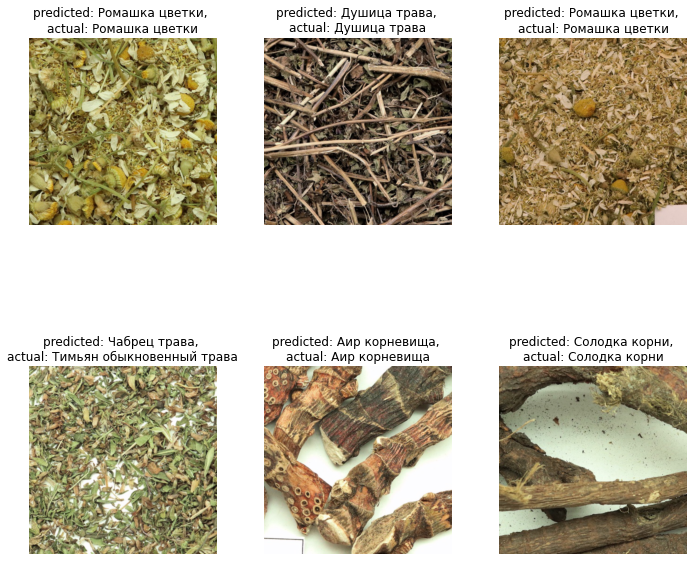

In [12]:
visualize_model(model_ft)
plt.tight_layout()
plt.show()

## TEST DATA VISALIZATION

Number of classes =  13
Dataset size 21


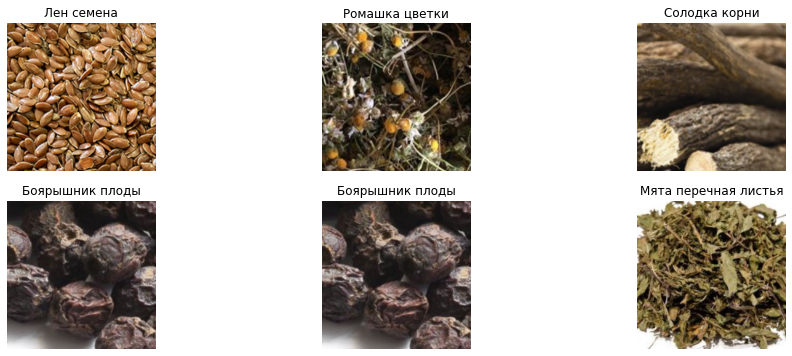

In [13]:
VALIDATION_PATH = "data/dataset/test/"

test_transform = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_datasets = datasets.ImageFolder(VALIDATION_PATH, test_transform)

testloader = torch.utils.data.DataLoader(test_datasets, batch_size=4,
                                         shuffle=True, num_workers=8)

test_class_names = test_datasets.classes
test_num_classes = len(test_class_names)
print("Number of classes = ", test_num_classes)
print("Dataset size", len(test_datasets))
# %%
plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image, label = testloader.dataset.__getitem__(np.random.choice(21))
    plt.imshow(im_convert(image))
    plt.title(test_class_names[label], color='black')
    plt.axis('off');
plt.show()

## PREDICT ON TEST DATA

In [14]:
def visualize_test_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):

            outputs = model(inputs.cuda())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, \nactual: {test_class_names[labels[j]]}',
                             color="black")

                """Imshow for Tensor."""
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

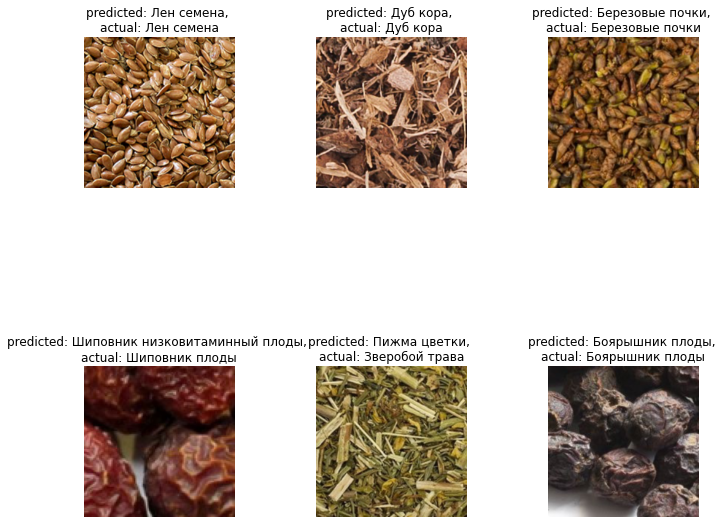

In [16]:
visualize_test_model(model_ft)
plt.tight_layout()
plt.show()